In [1]:
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util
from PIL import Image, ImageOps
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
configs = config_util.get_configs_from_pipeline_file('utilities/models/pipeline.config')
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore('C:/Temp/Training2/ckpt-10').expect_partial()


category_index = label_map_util.create_category_index_from_labelmap('data13_320/label_map.pbtxt')

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

[0.98424053 0.23659113 0.13478065 0.09627073 0.08578219 0.0786474
 0.07347374 0.06998526 0.06173761 0.0553435  0.05078614 0.04956453
 0.04250108 0.0376173  0.03544008 0.03501849 0.03401515 0.03399759
 0.03300402 0.03196193 0.02959852 0.02857473 0.027635   0.02676149
 0.02608079 0.02564008 0.02523234 0.02459132 0.02379836 0.02249658
 0.02247749 0.02213463 0.02166798 0.02161944 0.02154981 0.0214857
 0.02087549 0.02086012 0.02084305 0.02082435 0.02082101 0.02061757
 0.02057272 0.02049344 0.02039356 0.02034016 0.02027275 0.01989455
 0.01959003 0.01955655 0.01947588 0.01930768 0.01927215 0.01922
 0.01918404 0.01915553 0.01905419 0.01905181 0.01884714 0.01884071
 0.01878418 0.01861869 0.01857419 0.01853578 0.01848405 0.0183362
 0.01827464 0.01824863 0.01819971 0.01816607 0.01807906 0.01795781
 0.0178901  0.01784112 0.01783836 0.0175088  0.01715763 0.01696766
 0.01672226 0.01659486 0.01648392 0.01644295 0.0163708  0.0162523
 0.0161351  0.01612175 0.01611882 0.01608991 0.01602937 0.01592874
 0

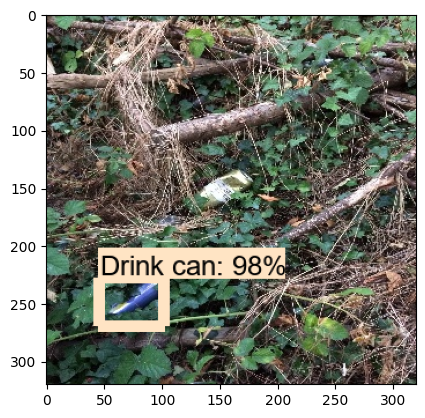

In [10]:
IMG_FILE = "TACO/data13_320/test/batch_1_000024.jpg"
img = Image.open(IMG_FILE)
img = ImageOps.exif_transpose(img)


image_np = np.array(img)

# Expand dimensions and convert to tensor
input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)

# Perform detection
detections = detect_fn(input_tensor)

# Process detection outputs
num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
detections['num_detections'] = num_detections


detections['detection_classes'] = detections['detection_classes'].astype(np.int64)


image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
    image_np_with_detections,
    detections['detection_boxes'],
    detections['detection_classes'] + 1,
    detections['detection_scores'],
    category_index,
    use_normalized_coordinates=True,
    max_boxes_to_draw=5,
    min_score_thresh=0.4,
    line_thickness=10,
    agnostic_mode=False
)

print(detections['detection_scores'])
print(detections['detection_classes'])
plt.imshow(image_np_with_detections)
plt.show()

In [26]:
import requests
import cv2
import numpy as np

# API Endpoint
url = "http://127.0.0.1:5000/predict"

# Image file to send
image_path = "TACO/data13_320/test/batch_1_000024.jpg"
files = {"image": open(image_path, "rb")}

# Send POST request
response = requests.post(url, files=files)
response_json = response.json()

# Extract detections from JSON response
detections = response_json.get("data", {}).get("detections", [])

# Load the original image
image = cv2.imread(image_path)
height, width, _ = image.shape

# Draw the bounding boxes
for detection in detections:
    # Get the bounding box in normalized coordinates
    box = detection["box"]  # [ymin, xmin, ymax, xmax]
    class_name = detection["class"]
    score = detection["score"]

    # Scale the box to image dimensions
    ymin, xmin, ymax, xmax = box
    ymin, xmin, ymax, xmax = (int(ymin * height), int(xmin * width), int(ymax * height), int(xmax * width))

    # Draw the rectangle
    color = (0, 255, 0)  # Green
    cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, 2)

    # Label the bounding box
    label = f"{class_name}: {score:.2f}"
    cv2.putText(image, label, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

# Display the image
cv2.imshow("Detections", image)
cv2.waitKey(0)
cv2.destroyAllWindows()
